# <center>Carrier Frequency Synchronization Introductory Demo</center>

This demo includes a graphical interface to specify the module's properties and is meant as an introduction to it's functionality. The **Modulation**, **Samples per symbol** and **Damping factor** and **Normalized loop bandwidth** fields, translate directly to the equivalent module properties.

The **Number of samples** field is the length of the input signal. it populates a variable *n* that can be used in the **Signal** field. Any valid Python expression can be used for the input signal (defined by the *sig* variable). An additional cell has been provided with experimental signals that can be pasted into the Signal field.

The output shows plots of the (uncorrected) input and (corrected) output signals. It will also report the detected offset.

A new instance should be created (using the **Init** button), whenever new parameters (or a new unrelated input signal) are specified. To clear the ouput, use the Jupyter Notebook's own shortcuts. Refer to the documentation in the Help menu.

In [ ]:
%matplotlib inline

import ipywidgets as widgets
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import sksdr
import utils

fsync = None
output_samples = None

def init(b):
    global fsync, disp
    mod = modulation_widget.value
    sps = sps_widget.value
    damp_factor = damp_factor_widget.value
    norm_loop_bw = norm_loop_bw_widget.value
    fsync = sksdr.FrequencySync(mod, sps, damp_factor, norm_loop_bw)
    with disp:
        print('Initiated with ' + repr(fsync))

def execute(b):
    global fsync, output_samples, disp
    n = np.arange(num_samples_widget.value)
    _locals = {'n': n}
    exec(signal_widget.value, None, _locals)
    sig = _locals['sig']
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    with disp:
        sksdr.time_plot([sig], [''], [1], 'Input Signal', fig=fig, gs=gs[0, 0])
        out, phase = fsync(sig)
        sksdr.time_plot([out], [''], [1], 'Output Signal', fig=fig, gs=gs[0, 1])
        sksdr.time_plot([phase], [''], [1], 'Phase Estimate', fig=fig, gs=gs[1, 0])
        plt.show()
        output_samples = out
        print('Output samples available in variable "output_samples"')

style = dict(utils.description_width_style)
settings_grid = widgets.GridspecLayout(3, 3)
settings_grid[0, 0] = modulation_widget = widgets.Dropdown(description='Modulation:', options=[('BPSK', sksdr.BPSK), ('QPSK', sksdr.QPSK)], value=sksdr.QPSK, continuous_update=False, style=style)
settings_grid[0, 1] = sps_widget = widgets.BoundedIntText(description='Samples per symbol:', value=4, min=1, max=np.iinfo(int).max, continuous_update=False, style=style)
settings_grid[0, 2] = damp_factor_widget = widgets.BoundedFloatText(description='Damping factor:', value=1.0, min=0, max=np.finfo(float).max, continuous_update=False, style=style)
settings_grid[1, 0] = norm_loop_bw_widget = widgets.BoundedFloatText(description='Normalized loop bandwidth (Hz): ', value=0.01, max=np.finfo(float).max, continuous_update=False, style=style)
settings_grid[2, 0] = num_samples_widget = widgets.BoundedIntText(description='Number of samples (n):', value=200, min=1, max=np.iinfo(int).max, continuous_update=False, style=style)
settings_grid[2, 1:] = signal_widget = widgets.Textarea(description='Signal (sig):', value='sig = np.exp(1j * 2 * np.pi * n / 12)', continuous_update=False, style=style, layout=widgets.Layout(height='auto', width='auto'))
init_button  = widgets.Button(description='Init', tooltip='Init')
init_button.on_click(init)
execute_button = widgets.Button(description='Execute', tooltip='Execute')
execute_button.on_click(execute)
disp = widgets.Output()
ui = widgets.VBox([
    settings_grid,
    widgets.HBox([init_button, execute_button]),
    disp
])
display(ui)

# QPSK signal with phase/frequency impairment and AWGN channel
This demo passes a QPSK modulated signal through a block that introduces phase and frequency offsets, and then through an AWGN channel. The received signal will initially appear in a circle. A frequency synchronizer corrects the received signal and it will become grouped around the constellation points.

DEBUG:sksdr.freq_sync:FSYNC init: phase_recovery_loop_bw=0.010000, phase_recovery_gain=1.000000, theta=0.009428, d=1.013422, p_gain=0.013157, i_gain=0.000175


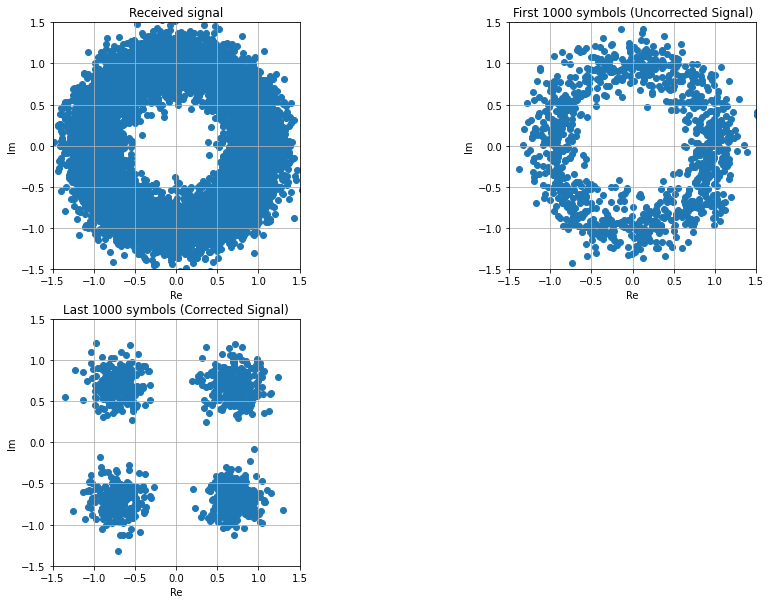

In [5]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import sksdr

# Create a phase and frequency offset object, where the frequency offset is 1% of the sample rate.
pfo = sksdr.PhaseFrequencyOffset(freq_offset=1e4, phase_offset=45, sample_rate=1e6)

# Create a carrier synchronizer object.
fsync = sksdr.FrequencySync(sps=1, mod=sksdr.QPSK, damp_factor=1/np.sqrt(2), norm_loop_bw=0.01)

# Generate random data symbols and apply QPSK modulation.
ints = np.random.randint(0, 4, 10000)
bits = sksdr.x2binlist(ints, 2)
psk = sksdr.PSKModulator(sksdr.QPSK, [0, 1, 3, 2], 1.0, np.pi/4)
mod_sig = psk.modulate(bits);

# Apply phase and frequency offsets. Then, pass the offset signal through an AWGN channel.
mod_sig_off, _ = pfo(mod_sig)
awgn = sksdr.AWGNChannel(snr=12)
rx_sig = awgn(mod_sig_off);

# Correct for the phase and frequency offset
sync_sig, _ = fsync(rx_sig)

# Setup figure
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Display the scatter plot of the received signal. The data appear in a circle instead of being grouped around the reference constellation points due to the frequency offset.
f = sksdr.scatter_plot(rx_sig, 'Received Signal', fig=fig, gs=gs[0, 0])

# Display the first 1000 symbols of corrected signal. The synchronizer has not yet converged so the data is not grouped around the reference constellation points.
f = sksdr.scatter_plot(sync_sig[:1000], 'First 1000 symbols (Uncorrected Signal)', fig=fig, gs=gs[0, 1])

# Display the last 1000 symbols of the corrected signal. The data is now aligned with the reference constellation.
f = sksdr.scatter_plot(sync_sig[-1000:], 'Last 1000 symbols (Corrected Signal)', fig=fig, gs=gs[1, 0])


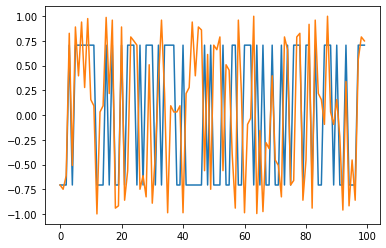

In [4]:
plt.plot(mod_sig.real[:100])
plt.plot(mod_sig_off.real[:100])